<a href="https://colab.research.google.com/github/isoittech/udemy-Hands-on-PyTorch/blob/main/05_CNN%E3%81%AB%E3%82%88%E3%82%8B%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E(CIFAR_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# deviceの確認

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 前処理

In [4]:
transform =transforms.Compose([
    transforms.ToTensor(), # 画像をTensorに変える、 チャネルファースト
    transforms.Normalize((0.5,), (0.5)) # RGBのチャネルごとに画像全体を正規化（平滑化・標準化）する
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 分類

In [5]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# データセットをデータローダに与える

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# 画像とラベルを抜く

In [7]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()
print(imgs.size()) # 32=ミニバッチの軸、3=チャネルの軸、32=高さと幅　←チャネルファーストになっている
labels

torch.Size([32, 3, 32, 32])


tensor([1, 0, 0, 6, 0, 2, 6, 5, 3, 8, 8, 0, 4, 2, 6, 2, 0, 4, 9, 7, 6, 1, 7, 2,
        0, 2, 9, 3, 6, 8, 8, 7])

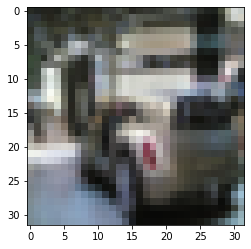

In [8]:
img = imgs[0]
# チャネルファーストからチャネルラストにする
img_permute = img.permute(1, 2, 0)

# 画像の明るさを調整
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)

# 画像表示
plt.imshow(img_permute)

# CNNモデル定義

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes): # 10クラスだったら10を与える
        super().__init__()
        # ネットワーク定義
        self.features = nn.Sequential(
            # inにはRGBのカラー画像を与えるので3を指定, outには任意
            # kernel_sizeは5  --> 2マスずつ縮小するので縮小させないためpaddingに2を与える
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32x32の画像が16x16になる

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8x8になる

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 4x4になる

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        # 特徴抽出
        # 全結合層
        # 1次元のベクトルにして渡す必要があるので、in_featuresには、
        # 最後のMaxPooling出力サイズ4x4とConv2dの出力サイズ128を積算したものを渡す
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    
    def forward(self, x):
        # 4x4x128の画像が得られる
        x = self.features(x)

        # classifierに与えるための変換
        # x.size(0)はバッチ数の32が返ってくる
        # viewの第2引数に-1を渡すと、4x4x128のベクトルデータが32行分、xに入る
        x = x.view(x.size(0), -1)
        # print(f"x-size: {x.size()}") # x-size: torch.Size([32, 2048])

        x = self.classifier(x)
        return x

# モデル定義

In [10]:
model = CNN(10)
model.to(device) # GPUに置く

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

# 損失関数と最適化

weight_decayでL2正則化を行う。重み付けが大きくなり過ぎないようにするためのもの。

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [12]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    # 
    # validation loop
    # 
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels  in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax( val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, \
        loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.350253400708038, acc: 0.5077375173568726,         loss: 1.0397167811378503, val acc: 0.6286940574645996
epoch: 1, loss: 0.8921832289744552, acc: 0.6857005953788757,         loss: 0.7985311004871758, val acc: 0.719648540019989
epoch: 2, loss: 0.7149612846202142, acc: 0.7503198981285095,         loss: 0.7739666942209481, val acc: 0.7394168972969055
epoch: 3, loss: 0.6085705644929554, acc: 0.787148118019104,         loss: 0.7260540701901189, val acc: 0.7574880123138428
epoch: 4, loss: 0.5271705172512673, acc: 0.8156989812850952,         loss: 0.7364056285577841, val acc: 0.7564895749092102
epoch: 5, loss: 0.4660383129798672, acc: 0.8357725739479065,         loss: 0.7126181607905288, val acc: 0.7642771601676941
epoch: 6, loss: 0.4127720978613931, acc: 0.8539667129516602,         loss: 0.700663765303243, val acc: 0.7677715420722961
epoch: 7, loss: 0.36747990171076467, acc: 0.871141254901886,         loss: 0.7347836853882757, val acc: 0.7669728398323059
epoch: 8, loss: 0.32

# グラフで確認してみる

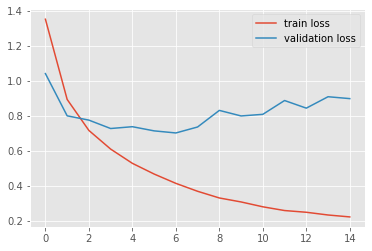

In [14]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

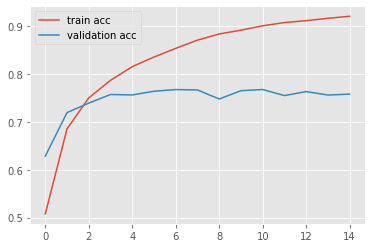

In [15]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()